In [1]:
!pip install torch-geometric
!pip install energyflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 8.8 MB/s eta 0:00:00


In [2]:
!pip install torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp311-cp311-linux_x86_64.whl size=2065948 sha256=5759c8215be843dd58e952d17316330611639b08aed3d826a7a9223f7e70020a
  Stored in directory: /root/.cache/pip/wheels/ef/de/7d/a4211822af99147b93800e9e204f0be21294e3c0b95b3b861a
Successfully built torch-cluster


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.data import Data, DataLoader
from torch_cluster import knn_graph  # Import KNN graph function
from sklearn.model_selection import train_test_split
import energyflow
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [5]:
qg_dataset = energyflow.qg_jets.load(num_data=50000, pad=True, ncol=4, generator='pythia')
x = qg_dataset[0]
y = qg_dataset[1]  # Labels: 0 (Gluon), 1 (Quark)
y = torch.tensor(y, dtype=torch.long)

In [6]:
features_to_consider = [0, 1, 2, 3]  # (pT, rapidity, azimuthal angle, energy)
x = x[:, :, features_to_consider]

In [7]:
jet_graphs = []
k_neighbors = 16

for i in range(len(x)):
    mask = x[i][:, 3] > 0  # Mask out zero-padded particles
    node_features = torch.tensor(x[i][mask], dtype=torch.float)
    edge_index = knn_graph(node_features, k=k_neighbors, loop=False)  # No self-loops

    jet_graphs.append(Data(x=node_features, edge_index=edge_index, y=y[i]))


In [8]:
train_data, val_data = train_test_split(jet_graphs, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
class GIN(torch.nn.Module):
    def __init__(self, node_feat_size, num_classes=2):
        super(GIN, self).__init__()
        self.conv1 = GINConv(nn.Sequential(nn.Linear(node_feat_size, 64), nn.ReLU(), nn.Linear(64, 64)))
        self.conv2 = GINConv(nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 128)))
        self.conv3 = GINConv(nn.Sequential(nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 256)))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [10]:
model = GIN(node_feat_size=len(features_to_consider)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

gin_model_path = "gin_model_weights_knn16.pth"

In [ ]:

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(data.y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    preds, true_labels, probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = loss_fn(out, data.y)
            total_loss += loss.item()
            preds.extend(out.argmax(dim=1).cpu().numpy())
            true_labels.extend(data.y.cpu().numpy())
            probs.append(F.softmax(out, dim=1).cpu().numpy())
            correct += out.argmax(dim=1).eq(data.y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset), np.array(preds), np.array(true_labels), np.concatenate(probs)

if not os.path.exists(gin_model_path):
    EPOCHS = 20
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader)
        val_loss, val_acc, preds, true_labels, probas = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.3f}, Train Acc {train_acc:.3f} | Val Loss {val_loss:.3f}, Val Acc {val_acc:.3f}")
    torch.save(model.state_dict(), gin_model_path)
    print("Model saved!")
else:
    model.load_state_dict(torch.load(gin_model_path))
    print("Loaded pre-trained GIN model.")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Train Loss 843.602, Train Acc 0.598 | Val Loss 1.940, Val Acc 0.637
Epoch 2: Train Loss 2.502, Train Acc 0.624 | Val Loss 2.759, Val Acc 0.588
Epoch 3: Train Loss 1.017, Train Acc 0.654 | Val Loss 0.708, Val Acc 0.655
Epoch 4: Train Loss 60.611, Train Acc 0.631 | Val Loss 1.257, Val Acc 0.570
Epoch 5: Train Loss 0.753, Train Acc 0.659 | Val Loss 0.669, Val Acc 0.705
Epoch 6: Train Loss 0.623, Train Acc 0.698 | Val Loss 0.610, Val Acc 0.708
Epoch 7: Train Loss 0.588, Train Acc 0.715 | Val Loss 0.563, Val Acc 0.731
Epoch 8: Train Loss 0.569, Train Acc 0.727 | Val Loss 0.575, Val Acc 0.727
Epoch 9: Train Loss 0.561, Train Acc 0.730 | Val Loss 0.564, Val Acc 0.728
Epoch 10: Train Loss 0.557, Train Acc 0.732 | Val Loss 0.554, Val Acc 0.740
Epoch 11: Train Loss 0.551, Train Acc 0.737 | Val Loss 0.566, Val Acc 0.713
Epoch 12: Train Loss 0.552, Train Acc 0.735 | Val Loss 0.548, Val Acc 0.750
Epoch 13: Train Loss 0.548, Train Acc 0.737 | Val Loss 0.567, Val Acc 0.723
Epoch 14: Train Lo

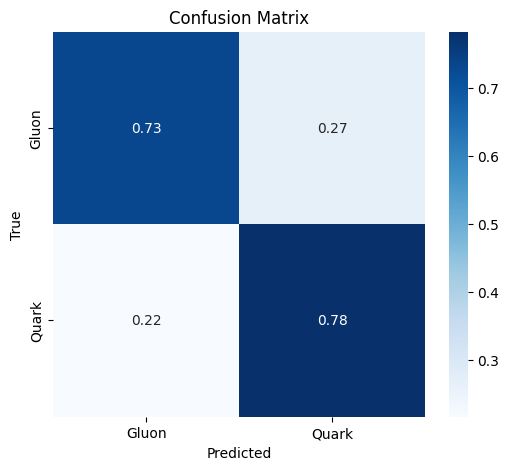

In [ ]:
def plot_confusion_matrix(true_labels, preds, classes):
    cm = confusion_matrix(true_labels, preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes, fmt='.2f')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(true_labels, preds, ["Gluon", "Quark"])




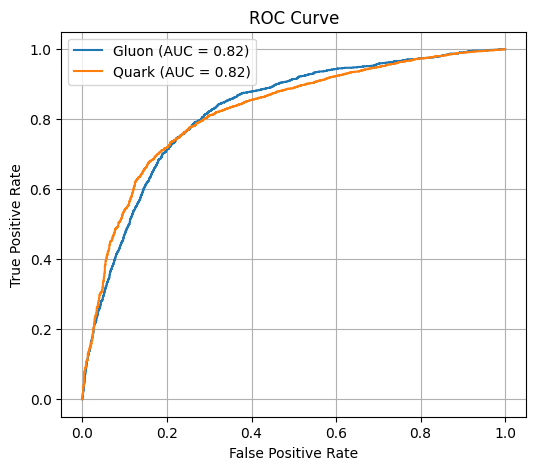

In [ ]:
def plot_roc_curve(true_labels, probas, classes):
    plt.figure(figsize=(6, 5))
    for i, class_name in enumerate(classes):
        tpr, fpr, _ = roc_curve((true_labels == i), probas[:, i])
        auc_value = auc(tpr, fpr)
        plt.plot(tpr, fpr, label=f'{class_name} (AUC = {auc_value:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(true_labels, probas, ["Gluon", "Quark"])